ドライブのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


ディレクトリ作成

In [ ]:
mkdir data

ディレクトリ移動

In [ ]:
cd data

/content/data


「auto_mgp.csv」アップロード

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving auto_mgp.csv to auto_mgp.csv


データ分析対象データ
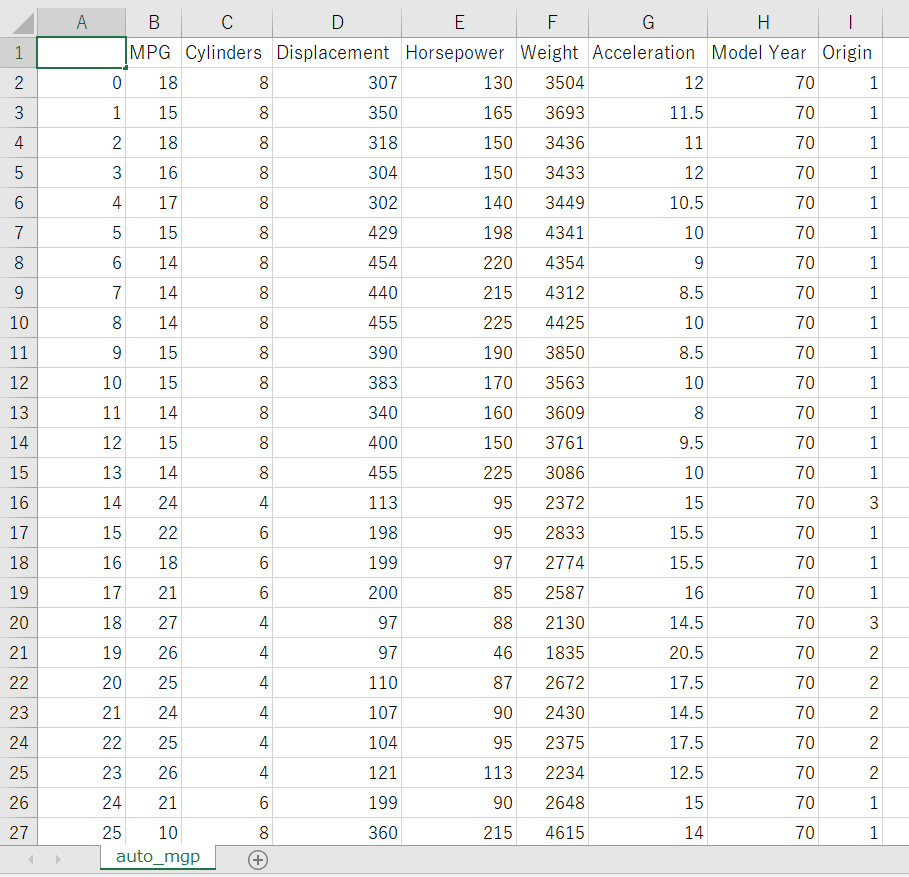

■正解データ：MPG（燃料1ガロンあたり何マイル走るかの燃費）

■特徴量候補

　①Cylinders：エンジンのシリンダー数

　②Displacement：排気量

　③Horsepower：馬力

　④Weight：車重

　⑤Acceleration：加速度

　⑥Model_Year：発表年

　⑦Origin：産出（1はアメ車、2は欧州車、3は日本車）

各種ライブラリのインポート

In [ ]:
#DataFrameを用いるためpandasをインポート
import pandas as pd
#グラフ描画を行うためmatplotlibをインポート
%matplotlib inline
#回帰モデルを用いるためLinearRegressionインポート
from sklearn.linear_model import LinearRegression
#訓練データとテストデータ分割のためtrain_test_splitインポート
from sklearn.model_selection import train_test_split
#標準化機能を用いるためStandardScalerをインポート
from sklearn.preprocessing import StandardScaler
#効率的なループ実装のためitertoolsをインポート
import itertools
#効率的な特徴量エンジニアリングのためPolynomialFeaturesをインポート
from sklearn.preprocessing import PolynomialFeatures
#マハラノビス距離を計算するためMinCovDetをインポート
from sklearn.covariance import MinCovDet
#リッジ回帰を用いるためモジュールをインポート
from sklearn.linear_model import Ridge
#ラッソ回帰を用いるためモジュールをインポート
from sklearn.linear_model import Lasso
#回帰木を用いるためモジュールDecisionTreeRegressorをインポート
from sklearn.tree import DecisionTreeRegressor

CSVファイル 「auto_mgp.csv」読み込み

In [ ]:
df = pd.read_csv('auto_mgp.csv',skipinitialspace=True)

読み込んだcsvファイルを確認するため、先頭・末尾それぞれ5行表示

In [ ]:
df.head()

,Unnamed: 0,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,0,18.0,8,307.0,130.0,3504,12.0,70,1
1,1,15.0,8,350.0,165.0,3693,11.5,70,1
2,2,18.0,8,318.0,150.0,3436,11.0,70,1
3,3,16.0,8,304.0,150.0,3433,12.0,70,1
4,4,17.0,8,302.0,140.0,3449,10.5,70,1


In [ ]:
df.tail()

,Unnamed: 0,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,393,27.0,4,140.0,86.0,2790,15.6,82,1
394,394,44.0,4,97.0,52.0,2130,24.6,82,2
395,395,32.0,4,135.0,84.0,2295,11.6,82,1
396,396,28.0,4,120.0,79.0,2625,18.6,82,1
397,397,31.0,4,119.0,82.0,2720,19.4,82,1


Originはカテゴリカルデータであるため、ダミー変数化

列2=0 and 列3=0⇒元の値は1（アメ車)

列2=1 and 列3=0⇒元の値は2（欧州車)

列2=0 and 列3=1⇒元の値は3（日本車)

In [ ]:
origin = pd.get_dummies(df['Origin'], drop_first = False,prefix='Origin')
df_tmp=pd.concat([df,origin,],axis=1)
df_new = df_tmp.drop(['Origin',],axis = 1)
df_new.head()

,Unnamed: 0,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_1,Origin_2,Origin_3
0,0,18.0,8,307.0,130.0,3504,12.0,70,1,0,0
1,1,15.0,8,350.0,165.0,3693,11.5,70,1,0,0
2,2,18.0,8,318.0,150.0,3436,11.0,70,1,0,0
3,3,16.0,8,304.0,150.0,3433,12.0,70,1,0,0
4,4,17.0,8,302.0,140.0,3449,10.5,70,1,0,0


Unnamed:0列は機械学習に必要ないため、列の削除

In [ ]:
df_new = df_new.drop(['Unnamed: 0',],axis = 1)
df_new.head(10)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_1,Origin_2,Origin_3
0,18.0,8,307.0,130.0,3504,12.0,70,1,0,0
1,15.0,8,350.0,165.0,3693,11.5,70,1,0,0
2,18.0,8,318.0,150.0,3436,11.0,70,1,0,0
3,16.0,8,304.0,150.0,3433,12.0,70,1,0,0
4,17.0,8,302.0,140.0,3449,10.5,70,1,0,0
5,15.0,8,429.0,198.0,4341,10.0,70,1,0,0
6,14.0,8,454.0,220.0,4354,9.0,70,1,0,0
7,14.0,8,440.0,215.0,4312,8.5,70,1,0,0
8,14.0,8,455.0,225.0,4425,10.0,70,1,0,0
9,15.0,8,390.0,190.0,3850,8.5,70,1,0,0


読み込んだデータフレームを訓練データとテストデータに分割する

１．訓練データ（train_val）とテストデータ(test)の比率は7:3、乱数シードは0

２．訓練データは必要な前処理を実施後、更に訓練データと検証データに分割する

In [ ]:
train_val, test = train_test_split(df_new,test_size = 0.3,random_state = 0)
train_val.head(20)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_1,Origin_2,Origin_3
230,15.5,8,350.0,170.0,4165,11.4,77,1,0,0
357,32.9,4,119.0,100.0,2615,14.8,81,0,0,1
140,14.0,8,304.0,150.0,4257,15.5,74,1,0,0
22,25.0,4,104.0,95.0,2375,17.5,70,0,1,0
250,19.4,8,318.0,140.0,3735,13.2,78,1,0,0
155,15.0,6,250.0,72.0,3158,19.5,75,1,0,0
356,32.4,4,108.0,75.0,2350,16.8,81,0,0,1
216,31.5,4,98.0,68.0,2045,18.5,77,0,0,1
186,27.0,4,101.0,83.0,2202,15.3,76,0,1,0
281,19.8,6,200.0,85.0,2990,18.2,79,1,0,0


前処理①（欠損値の穴埋め）

欠損値の確認

In [ ]:
train_val.isnull().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      5
Weight          0
Acceleration    0
Model Year      0
Origin_1        0
Origin_2        0
Origin_3        0
dtype: int64

１．Horsepower：馬力の欠損値を重回帰で穴埋め

２．欠損値がなくなっているか確認

In [ ]:
#欠損値を削除したデータフレームを作成
non_train_val = train_val.dropna()
#特徴量データは正解データ以外を指定
col = ['MPG','Cylinders','Displacement','Weight','Acceleration','Model Year','Origin_1','Origin_2','Origin_3']
nx = non_train_val.loc[:,col]
#正解データは欠損値が含まれる列
nt = non_train_val['Horsepower']
#学習
nmodel = LinearRegression()
nmodel.fit(nx,nt)
#欠損行の抜き出し
condition = train_val['Horsepower'].isnull()
non_data = train_val.loc[condition]
#欠損行の入力に必要な特徴量を抜き出してモデルで予測
kx = non_data.loc[:,col]
pred = nmodel.predict(kx)
#欠損行を抜き出して、予測値を代入
train_val.loc[condition,'Horsepower'] = pred
#欠損値確認
train_val.isnull().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin_1        0
Origin_2        0
Origin_3        0
dtype: int64

前処理②（外れ値の除外）

外れ値が存在するかグラフ描画で確認

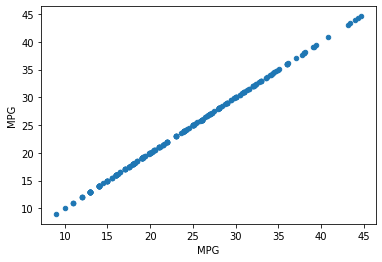

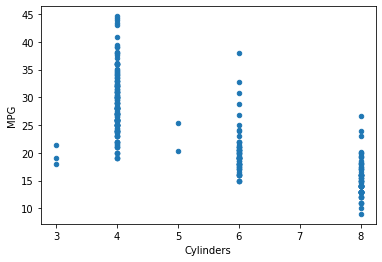

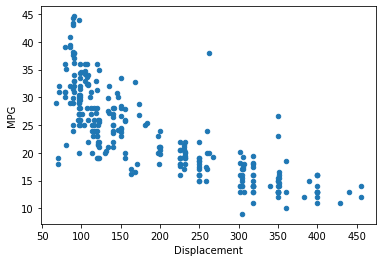

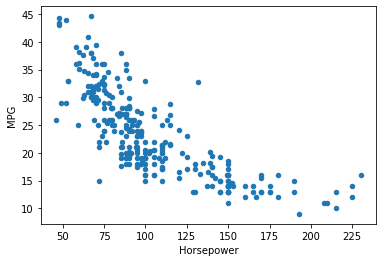

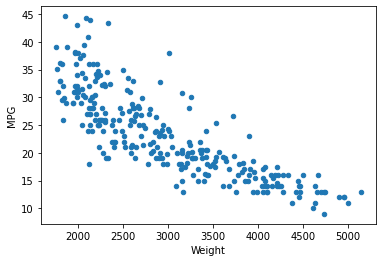

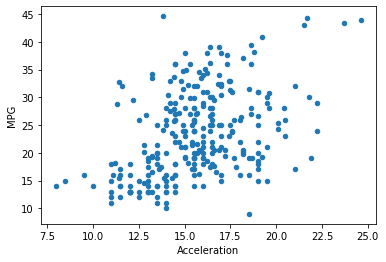

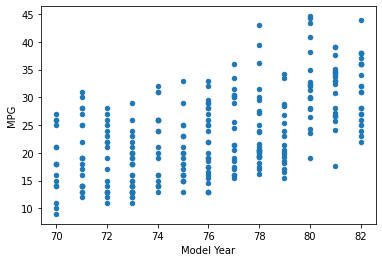

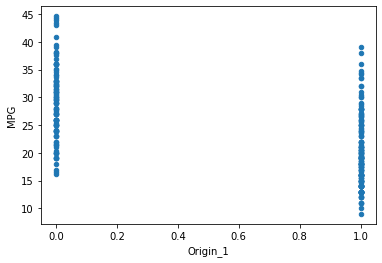

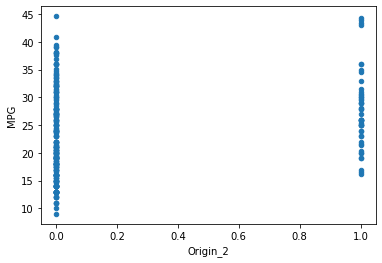

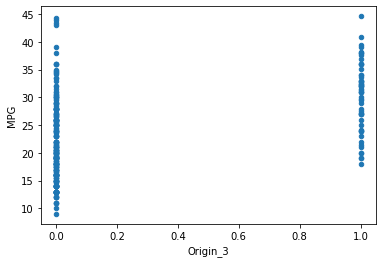

In [ ]:
colname = train_val.columns
for name in colname:
  train_val.plot(kind='scatter',x = name , y = 'MPG')  #一旦すべての散布図を表示

外れ値を考慮する

マハラノビス距離を求める

In [ ]:
#インデックス番号の再設定
train_val = train_val.reset_index(drop=True)
#マハラビノス距離を計算する準備
mcd = MinCovDet(random_state = 0,support_fraction = 0.7)
#共分散行列を計算
mcd.fit(train_val)
#マハラビノス計算
distance = mcd.mahalanobis(train_val)
print(distance)

[  9.62315405  10.23357574   9.58625173  18.17561528   5.29804155
  22.35354402   5.5010563    7.23709766   6.32366537   9.06429513
   6.68086017  11.18930982   1.94541552   3.9045112   13.34127191
 102.07270408  23.45042554   8.81917161   7.94599109   3.11625998
  15.26127355   7.95294277   7.31788899  25.35720697   8.94924232
  33.14144334  10.73980707  89.21774011  41.20436867  15.23268684
   7.37159404  13.82661442  33.43574223   7.33360393  18.4217278
   3.41950332  16.67814663  30.33069243   2.2064408    8.92514158
  11.90551605  10.29634962   8.39921195   6.48690219  10.10475394
   2.34900011  15.69131212   9.61358542   5.25225541   1.97056769
   8.39259266  13.7974546    7.02721233  21.72345671  21.19870744
  10.23196055   7.02257275   5.09722858  12.81970825   8.87048805
   9.81064376  10.13523007   5.25160298  12.66404921   9.67830459
   9.21473074   9.59730508   2.27000138  23.81133614  85.13307674
  11.72123807  58.29379675  11.68708883  10.03216109  25.76227042
  26.998777

箱ひげ図で外れ値を描画

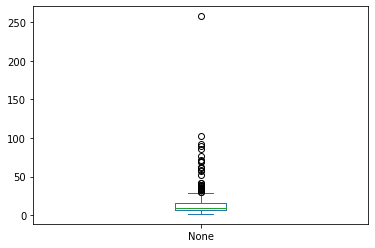

In [ ]:
distance = pd.Series(distance)
distance.plot(kind='box')

基本統計量算出

In [ ]:
tmp = distance.describe()
tmp

count    278.000000
mean      15.862111
std       21.294300
min        1.653176
25%        6.903080
50%        9.680177
75%       15.745220
max      257.729250
dtype: float64

四分位範囲を用いた外れ値の判定

In [ ]:
iqr = tmp['75%'] -tmp['25%']
jougen = 1.5 * (iqr) + tmp['75%']
kagen = tmp['25%'] - 1.5 * (iqr)
outliner = distance[(distance > jougen) | (distance < kagen)].index
print(outliner)

Int64Index([ 15,  25,  27,  28,  32,  37,  69,  71,  82,  88,  91,  95, 106,
            107, 132, 145, 149, 157, 185, 187, 207, 227, 231, 239, 248, 253,
            263, 267, 268, 269],
           dtype='int64')


外れ値の削除

In [ ]:
train_val2 = train_val.drop(outliner,axis=0)
train_val2.head(30)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_1,Origin_2,Origin_3
0,15.5,8,350.0,170.0,4165,11.4,77,1,0,0
1,32.9,4,119.0,100.0,2615,14.8,81,0,0,1
2,14.0,8,304.0,150.0,4257,15.5,74,1,0,0
3,25.0,4,104.0,95.0,2375,17.5,70,0,1,0
4,19.4,8,318.0,140.0,3735,13.2,78,1,0,0
5,15.0,6,250.0,72.0,3158,19.5,75,1,0,0
6,32.4,4,108.0,75.0,2350,16.8,81,0,0,1
7,31.5,4,98.0,68.0,2045,18.5,77,0,0,1
8,27.0,4,101.0,83.0,2202,15.3,76,0,1,0
9,19.8,6,200.0,85.0,2990,18.2,79,1,0,0


散布図を再表示

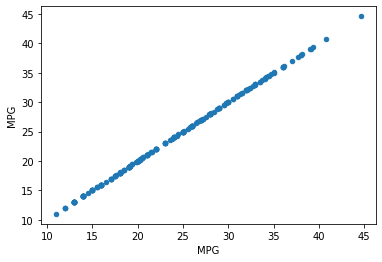

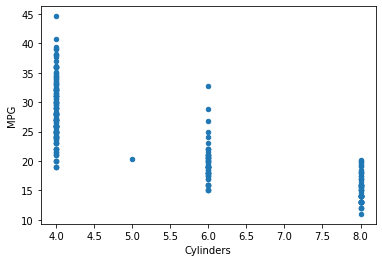

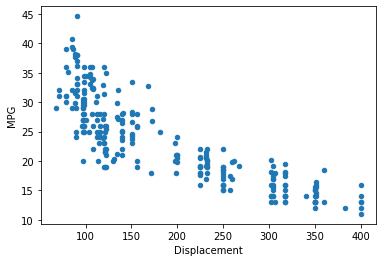

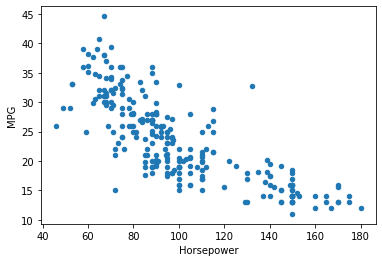

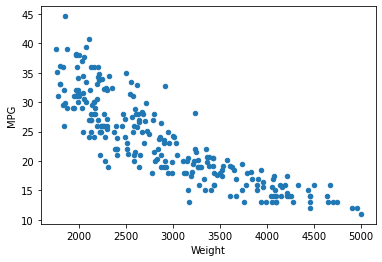

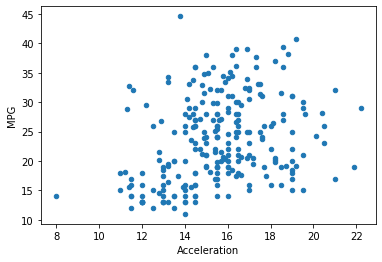

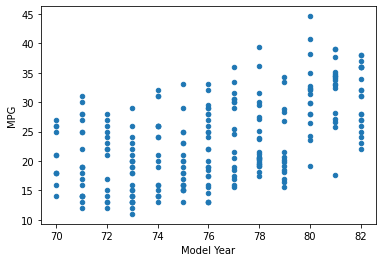

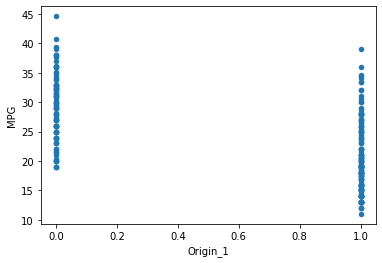

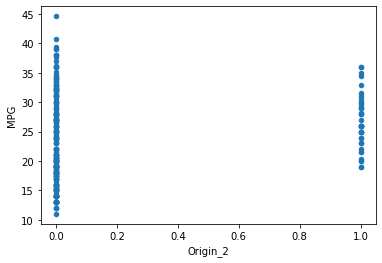

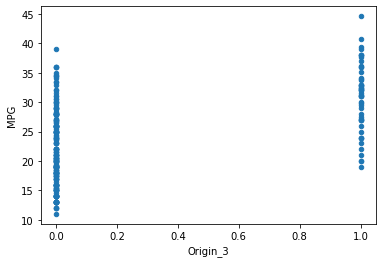

In [ ]:
colname = train_val2.columns
for name in colname:
  train_val2.plot(kind='scatter',x = name , y = 'MPG')  #一旦すべての散布図を表示

正解データと各特徴量の相関係数を求める


In [ ]:
train_val = train_val2.copy()
train_cor = train_val.corr()['MPG']
abs_cor = train_cor.map(abs)
abs_cor.sort_values(ascending = False)

MPG             1.000000
Weight          0.855255
Displacement    0.842726
Cylinders       0.798039
Horsepower      0.792061
Origin_1        0.589482
Model Year      0.538866
Origin_3        0.525957
Acceleration    0.314258
Origin_2        0.192093
Name: MPG, dtype: float64

正解データを抽出

In [ ]:
t = train_val[['MPG']]
t.head()

,MPG
0,15.5
1,32.9
2,14.0
3,25.0
4,19.4


全ての特徴量データと正解データをから基準となる決定係数算出

In [ ]:
col = ['Cylinders','Displacement','Horsepower','Weight','Acceleration','Model Year','Origin_1','Origin_2','Origin_3',]
x = train_val[col]
x_train, x_val, y_train, y_val = train_test_split(x, t, test_size = 0.3, random_state = 0) #訓練データと検証データに分割
#標準化
sc_model_x = StandardScaler()
sc_model_y = StandardScaler()
sc_model_x.fit(x_train)
sc_x_train = sc_model_x.transform(x_train)
sc_model_y.fit(y_train)
sc_y_train = sc_model_y.transform(y_train)
# 学習
model = LinearRegression()
model.fit(sc_x_train,sc_y_train)
#検証データを標準化
sc_x_val = sc_model_x.transform(x_val)
sc_y_val = sc_model_y.transform(y_val)
# 訓練データと検証データの決定係数計算
train_score = model.score(sc_x_train, sc_y_train)
val_score = model.score(sc_x_val, sc_y_val)
print('訓練データによる決定係数')
print(train_score)
print('検証データによる決定係数')
print(val_score)

訓練データによる決定係数
0.8518697886939964
検証データによる決定係数
0.871074357255701


関数learnの作成

In [ ]:
# 標準化学習関数
def learn(x, t):
    x_train, x_val, y_train, y_val = train_test_split(x, t, test_size = 0.3, random_state = 0) #訓練データと検証データに分割
    # 標準化
    sc_model_x = StandardScaler()
    sc_model_y = StandardScaler()
    sc_model_x.fit(x_train)
    sc_x_train = sc_model_x.transform(x_train)
    sc_model_y.fit(y_train)
    sc_y_train = sc_model_y.transform(y_train)
    # 学習
    model = LinearRegression()
    model.fit(sc_x_train,sc_y_train)
    #検証データを標準化
    sc_x_val = sc_model_x.transform(x_val)
    sc_y_val = sc_model_y.transform(y_val)
    # 訓練データと検証データの決定係数計算
    train_score = model.score(sc_x_train, sc_y_train)
    val_score = model.score(sc_x_val, sc_y_val)
    return train_score, val_score

全ての列の組み合わせより最大となる決定係数を求める。

　①Cylinders：エンジンのシリンダー数

　②Displacement：排気量

　③Horsepower：馬力

　④Weight：車重

　⑤Acceleration：加速度

　⑥Model_Year：発表年

　⑦Origin_1(アメ車)

　⑧Origin_2(欧州車)

　⑨Origin_3(日本車)


In [ ]:
col = ['Cylinders','Displacement','Horsepower','Weight','Acceleration','Model Year','Origin_1','Origin_2','Origin_3',]
max = 0
max_train_val=[]
for n in range(1,len(col)+1): #nは全列が対象
  for pair in itertools.combinations(col,n): #全パターンの組み合わせ生成
    x = train_val.loc[:,pair]
    x_score, t_score = learn(x, t)
    if t_score > max: #最大値を求める処理
      print(pair)
      print('検証データの決定係数:',t_score)
      max = t_score
      max_train_val = x
print("■決定係数の最大値")
print(max)

('Cylinders',)
検証データの決定係数: 0.6385919974887002
('Displacement',)
検証データの決定係数: 0.7476220395822962
('Weight',)
検証データの決定係数: 0.7833928333400308
('Displacement', 'Weight')
検証データの決定係数: 0.7898376496027064
('Displacement', 'Model Year')
検証データの決定係数: 0.8000016275685985
('Weight', 'Model Year')
検証データの決定係数: 0.8576437759408297
('Horsepower', 'Weight', 'Model Year')
検証データの決定係数: 0.8576694222549701
('Weight', 'Acceleration', 'Model Year')
検証データの決定係数: 0.8587784844609004
('Weight', 'Model Year', 'Origin_1')
検証データの決定係数: 0.8645872568204068
('Weight', 'Model Year', 'Origin_3')
検証データの決定係数: 0.8752411035973395
('Weight', 'Acceleration', 'Model Year', 'Origin_3')
検証データの決定係数: 0.8763073362531829
('Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin_3')
検証データの決定係数: 0.8785456256207427
■決定係数の最大値
0.8785456256207427


特徴量エンジニアリング

Weightを累乗

累乗値は最大値を算出

In [ ]:
temp = max_train_val.copy()
j=1
max_score = 0
temp['Weight2'] = train_val['Weight']**j
x_score, t_score = learn(temp, t)
while max_score <= t_score:
  j += 1 
  temp['Weight2'] = train_val['Weight']**j
  x_score, t_score = learn(temp, t)
  if max_score < t_score:
    max_score = t_score
print('累乗の最適値')
print(j)
print('訓練データによる決定係数')
print(x_score)
print('検証データによる決定係数')
print(t_score)

累乗の最適値
3
訓練データによる決定係数
0.886268827157669
検証データによる決定係数
0.8965540756966688


↑決定係数が最大のため採用

Displacementを累乗

累乗値は最大値を算出

In [ ]:
j=1
max_score = 0
temp['Displacement2'] = train_val['Displacement']**j
x_score, t_score = learn(temp, t)
while max_score <= t_score:
  j += 1 
  temp['Displacement2'] = train_val['Displacement']**j
  x_score, t_score = learn(temp, t)
  if max_score < t_score:
    max_score = t_score
print('累乗の最適値')
print(j)
print('訓練データによる決定係数')
print(x_score)
print('検証データによる決定係数')
print(t_score)

累乗の最適値
8
訓練データによる決定係数
0.8863910817590358
検証データによる決定係数
0.897236250174143


↑決定係数が最大のため採用

Horsepowerを累乗

累乗値は最大値を算出

In [ ]:
j=1
max_score = 0
temp['Horsepower2'] = train_val['Horsepower']**j
x_score, t_score = learn(temp, t)
while max_score <= t_score:
  j += 1 
  temp['Horsepower2'] = train_val['Horsepower']**j
  x_score, t_score = learn(temp, t)
  if max_score < t_score:
    max_score = t_score
print('累乗の最適値')
print(j)
print('訓練データによる決定係数')
print(x_score)
print('検証データによる決定係数')
print(t_score)

累乗の最適値
4
訓練データによる決定係数
0.8873457960988832
検証データによる決定係数
0.9011515702577197


↑決定係数が最大のため採用

Cylindersを累乗

累乗値は最大値を算出

In [ ]:
j=1
max_score = 0
temp['Cylinders2'] = train_val['Cylinders']**j
x_score, t_score = learn(temp, t)
while max_score <= t_score:
  j += 1 
  temp['Cylinders2'] = train_val['Cylinders']**j
  x_score, t_score = learn(temp, t)
  if max_score < t_score:
    max_score = t_score
print('累乗の最適値')
print(j)
print('訓練データによる決定係数')
print(x_score)
print('検証データによる決定係数')
print(t_score)

累乗の最適値
3
訓練データによる決定係数
0.8893622781983826
検証データによる決定係数
0.8961888311078712


↑決定係数が最大でないため不採用

Model Yearを累乗

累乗値は最大値を算出

In [ ]:
temp = temp.drop('Cylinders2',axis=1)
j=1
max_score = 0
temp['Model Year2'] = train_val['Model Year']**j
x_score, t_score = learn(temp, t)
while max_score <= t_score:
  j += 1 
  temp['Model Year2'] = train_val['Model Year']**j
  x_score, t_score = learn(temp, t)
  if max_score < t_score:
    max_score = t_score
print('累乗の最適値')
print(j)
print('訓練データによる決定係数')
print(x_score)
print('検証データによる決定係数')
print(t_score)

累乗の最適値
3
訓練データによる決定係数
0.8907326203064874
検証データによる決定係数
0.9061987792403665


↑決定係数が最大のため採用

Accelerationを累乗

累乗値は最大値を算出

In [ ]:
j=1
max_score = 0
temp['Acceleration2'] = train_val['Acceleration']**j
x_score, t_score = learn(temp, t)
while max_score <= t_score:
  j += 1 
  temp['Acceleration2'] = train_val['Acceleration']**j
  x_score, t_score = learn(temp, t)
  if max_score < t_score:
    max_score = t_score
print('累乗の最適値')
print(j)
print('訓練データによる決定係数')
print(x_score)
print('検証データによる決定係数')
print(t_score)

累乗の最適値
4
訓練データによる決定係数
0.8911367358627302
検証データによる決定係数
0.9077846804735323


↑決定係数が最大のため採用

Weight*Displacementを掛ける

In [ ]:
temp['WD'] = train_val['Weight']*train_val['Displacement']
x_score, t_score = learn(temp, t)
print('訓練データによる決定係数')
print(x_score)
print('検証データによる決定係数')
print(t_score)

訓練データによる決定係数
0.892844772405872
検証データによる決定係数
0.9091402249027353


↑決定係数が最大のため採用

Weight*Horsepowerを掛ける

In [ ]:
temp['WH'] = train_val['Weight']*train_val['Horsepower']
x_score, t_score = learn(temp, t)
print('訓練データによる決定係数')
print(x_score)
print('検証データによる決定係数')
print(t_score)

訓練データによる決定係数
0.8939681260518247
検証データによる決定係数
0.9117416657556549


↑決定係数が最大のため採用

Weight*Cylindersを掛ける

In [ ]:
temp['WC'] = train_val['Weight']*train_val['Cylinders']
x_score, t_score = learn(temp, t)
print('訓練データによる決定係数')
print(x_score)
print('検証データによる決定係数')
print(t_score)

訓練データによる決定係数
0.8941026157751681
検証データによる決定係数
0.9100236312247212


↑決定係数が最大でないため不採用

Weight*Model Yearを掛ける

In [ ]:
temp = temp.drop('WC',axis=1)
temp['WM'] = train_val['Weight']*train_val['Model Year']
x_score, t_score = learn(temp, t)
print('訓練データによる決定係数')
print(x_score)
print('検証データによる決定係数')
print(t_score)

訓練データによる決定係数
0.8940301281041816
検証データによる決定係数
0.9132451218958171


↑決定係数が最大のため採用

Weight*Accelerationを掛ける

In [ ]:
temp['WA'] = train_val['Weight']*train_val['Acceleration']
x_score, t_score = learn(temp, t)
print('訓練データによる決定係数')
print(x_score)
print('検証データによる決定係数')
print(t_score)

訓練データによる決定係数
0.894307717888873
検証データによる決定係数
0.9118161543161183


↑決定係数が最大でないため不採用

Displacement*Horsepowerを掛ける

In [ ]:
temp = temp.drop('WA',axis=1)
temp['DH'] = train_val['Displacement']*train_val['Horsepower']
x_score, t_score = learn(temp, t)
print('訓練データによる決定係数')
print(x_score)
print('検証データによる決定係数')
print(t_score)

訓練データによる決定係数
0.8946394882209455
検証データによる決定係数
0.9095253836918489


↑決定係数が最大でないため不採用

Displacement*Cylindersを掛ける

In [ ]:
temp = temp.drop('DH',axis=1)
temp['DC'] = train_val['Displacement']*train_val['Cylinders']
x_score, t_score = learn(temp, t)
print('訓練データによる決定係数')
print(x_score)
print('検証データによる決定係数')
print(t_score)

訓練データによる決定係数
0.8948958098593638
検証データによる決定係数
0.908037547706578


↑決定係数が最大でないため不採用

Displacement*Model Yearを掛ける

In [ ]:
temp = temp.drop('DC',axis=1)
temp['DM'] = train_val['Displacement']*train_val['Model Year']
x_score, t_score = learn(temp, t)
print('訓練データによる決定係数')
print(x_score)
print('検証データによる決定係数')
print(t_score)

訓練データによる決定係数
0.8951605559679702
検証データによる決定係数
0.9182758752455742


↑決定係数が最大なため採用

Displacement*Accelerationを掛ける

In [ ]:
temp['DA'] = train_val['Displacement']*train_val['Acceleration']
x_score, t_score = learn(temp, t)
print('訓練データによる決定係数')
print(x_score)
print('検証データによる決定係数')
print(t_score)

訓練データによる決定係数
0.8959704681429908
検証データによる決定係数
0.9148532871478796


↑決定係数が最大でないため不採用

Horsepower*Cylindersを掛ける

In [ ]:
temp = temp.drop('DA',axis=1)
temp['HC'] = train_val['Horsepower']*train_val['Cylinders']
x_score, t_score = learn(temp, t)
print('訓練データによる決定係数')
print(x_score)
print('検証データによる決定係数')
print(t_score)

訓練データによる決定係数
0.8954028955427435
検証データによる決定係数
0.9154099123462489


↑決定係数が最大でないため不採用

Horsepower*Model Yearを掛ける

In [ ]:
temp = temp.drop('HC',axis=1)
temp['HM'] = train_val['Horsepower']*train_val['Model Year']
x_score, t_score = learn(temp, t)
print('訓練データによる決定係数')
print(x_score)
print('検証データによる決定係数')
print(t_score)

訓練データによる決定係数
0.8962749984461486
検証データによる決定係数
0.9134388762289518


↑決定係数が最大でないため不採用

Horsepower*Accelerationを掛ける

In [ ]:
temp = temp.drop('HM',axis=1)
temp['HA'] = train_val['Horsepower']*train_val['Acceleration']
x_score, t_score = learn(temp, t)
print('訓練データによる決定係数')
print(x_score)
print('検証データによる決定係数')
print(t_score)

訓練データによる決定係数
0.8951682233501429
検証データによる決定係数
0.9181415443734773


↑決定係数が最大でないため不採用

Cylinders*Model Yearを掛ける

In [ ]:
temp = temp.drop('HA',axis=1)
temp['CM'] = train_val['Cylinders']*train_val['Model Year']
x_score, t_score = learn(temp, t)
print('訓練データによる決定係数')
print(x_score)
print('検証データによる決定係数')
print(t_score)

訓練データによる決定係数
0.895213113724917
検証データによる決定係数
0.9170488552311559


↑決定係数が最大でないため不採用

Cylinders*Accelerationを掛ける

In [ ]:
temp = temp.drop('CM',axis=1)
temp['CA'] = train_val['Cylinders']*train_val['Acceleration']
x_score, t_score = learn(temp, t)
print('訓練データによる決定係数')
print(x_score)
print('検証データによる決定係数')
print(t_score)

訓練データによる決定係数
0.8951895866568403
検証データによる決定係数
0.9189433917064187


↑決定係数が最大のため採用

Model Year*Accelerationを掛ける

In [ ]:
temp['MA'] = train_val['Model Year']*train_val['Acceleration']
x_score, t_score = learn(temp, t)
print('訓練データによる決定係数')
print(x_score)
print('検証データによる決定係数')
print(t_score)

訓練データによる決定係数
0.8959242762985604
検証データによる決定係数
0.9155634446141097


↑決定係数が最大でないため不採用

In [ ]:
temp = temp.drop('MA',axis=1)

特徴量エンジニアリングの結果表示

In [ ]:
print(temp)

     Horsepower  Weight  Acceleration  Model Year  Origin_3      Weight2  \
0         170.0    4165          11.4          77         0  72251192125   
1         100.0    2615          14.8          81         1  17881958375   
2         150.0    4257          15.5          74         0  77145562593   
3          95.0    2375          17.5          70         0  13396484375   
4         140.0    3735          13.2          78         0  52104090375   
..          ...     ...           ...         ...       ...          ...   
273       105.0    2800          14.4          80         0  21952000000   
274       105.0    3353          14.5          76         0  37696467977   
275        49.0    1867          19.5          73         0   6507781363   
276       100.0    3282          15.0          71         0  35352141768   
277        71.0    2223          16.5          75         0  10985463567   

     Displacement2  Horsepower2  Model Year2  Acceleration2         WD  \
0     2.25187

特徴量エンジニアリング終了

ここから得られた列を用いて線形回帰、リッジ回帰、ラッソ回帰、回帰木による決定係数を比較する

①線形回帰による決定係数の算出

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(temp,t, test_size = 0.3, random_state = 0)
# 標準化
sc_model_x = StandardScaler()
sc_model_y = StandardScaler()
sc_model_x.fit(x_train)
sc_x_train = sc_model_x.transform(x_train)
sc_model_y.fit(y_train)
sc_y_train = sc_model_y.transform(y_train)
# 学習
model = LinearRegression()
model.fit(sc_x_train,sc_y_train)
#検証データを標準化
sc_x_val = sc_model_x.transform(x_test)
sc_y_val = sc_model_y.transform(y_test)
# 訓練データと検証データの決定係数計算
train_score = model.score(sc_x_train, sc_y_train)
val_score = model.score(sc_x_val, sc_y_val)
print('訓練データによる決定係数')
print(train_score)
print('検証データによる決定係数')
print('★',val_score)

訓練データによる決定係数
0.8951895866568403
検証データによる決定係数
★ 0.9189433917064187


②リッジ回帰による決定係数の算出（結果表示まで15秒ほどかかります）

In [ ]:
maxScore = 0
maxIndex = 0
x_train, x_test, y_train, y_test = train_test_split(temp,t, test_size = 0.3, random_state = 0)
# range関数により整数列を1～2000生成
for i in range(1, 2001):
    num = i/100
    ridgeModel = Ridge(random_state = 0, alpha = num)
    ridgeModel.fit(x_train, y_train)
    result = ridgeModel.score(x_test, y_test)
    if result > maxScore:
        maxScore = result
        maxIndex = num
print('■最適な定数')
print(maxIndex)
print('その時の検証データの決定係数')
print(maxScore)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.04153e-42): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.04553e-42): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.04952e-42): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.05352e-42): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-condit

■最適な定数
2.57
その時の検証データの決定係数
0.9196691522038298


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=8.98102e-42): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=8.98508e-42): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=8.98915e-42): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=8.99321e-42): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-condit

定数が2.57と求まったため、リッジ回帰を実行する

In [ ]:

x_train, x_test, y_train, y_test = train_test_split(temp,t, test_size = 0.3, random_state = 0)
# モデルの作成
ridgeModel = Ridge(alpha = 2.57) #alphaは先に求めた値
ridgeModel.fit(x_train, y_train) # 学習
print('訓練データによる決定係数')
print(ridgeModel.score(x_train, y_train)) # 訓練データの決定係数
print('検証データによる決定係数')
print('★',ridgeModel.score(x_test, y_test)) # テストデータの決定係数

訓練データによる決定係数
0.8947167583675404
検証データによる決定係数
★ 0.9196691522038298


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.06689e-42): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


③ラッソ回帰による決定係数の算出（実行時間15秒程度）

In [ ]:
maxScore = 0
maxIndex = 0
x_train, x_test, y_train, y_test = train_test_split(temp,t, test_size = 0.3, random_state = 0)
# range関数により整数列を1～2000生成
for i in range(1, 2001):
    num = i/100
    lassoModel = Lasso(random_state = 0, alpha = num)
    lassoModel.fit(x_train, y_train)
    result = lassoModel.score(x_test, y_test)
    if result > maxScore:
        maxScore = result
        maxIndex = num
print('■最適な定数')
print(maxIndex)
print('その時の検証データの決定係数')
print(maxScore)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.688e+02, tolerance: 8.730e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.736e+02, tolerance: 8.730e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

■最適な定数
0.01
その時の検証データの決定係数
0.917793722069417


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.946e+02, tolerance: 8.730e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.946e+02, tolerance: 8.730e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


定数が0.01と求まったため、ラッソ回帰を実行する

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(temp,t, test_size = 0.3, random_state = 0)

# ラッソ回帰のモデル作成（alphaは正則化項につく定数）
lassomodel = Lasso(alpha = 0.01)
lassomodel.fit(x_train, y_train)
print('訓練データによる決定係数')
print(lassomodel.score(x_train, y_train)) # 訓練データの決定係数
print('検証データによる決定係数')
print('★',lassomodel.score(x_test, y_test)) # テストデータの決定係数

訓練データによる決定係数
0.8936126277122405
検証データによる決定係数
★ 0.917793722069417


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.688e+02, tolerance: 8.730e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


④回帰木による決定係数の算出

In [ ]:

x_train, x_test, y_train, y_test = train_test_split(temp,t, test_size = 0.3, random_state = 0)
max = 0
n = 2
treemodel = DecisionTreeRegressor(max_depth = 1,random_state = 0)
treemodel.fit(x_train,y_train)
a = treemodel.score(x_test,y_test)
while n < 100:
  treemodel = DecisionTreeRegressor(max_depth = n,random_state = 0)
  treemodel.fit(x_train,y_train)
  a = treemodel.score(x_test,y_test)
  n += 1
  if max < a:
    max = a
    max_n = n
print(max_n)
print(max)

5
0.8493963179130375


深さが5に決定したため、回帰木を実行する

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(temp,t, test_size = 0.3, random_state = 0)

treemodel = DecisionTreeRegressor(max_depth = 5,random_state= 0)
treemodel.fit(x_train, y_train)
print('訓練データによる決定係数')
print(treemodel.score(x_train, y_train)) # 訓練データの決定係数
print('検証データによる決定係数')
print('★',treemodel.score(x_test, y_test)) # テストデータの決定係数

訓練データによる決定係数
0.9568455548796524
検証データによる決定係数
★ 0.8426377161977477


特徴量エンジニアリングの結果を用いたデータによって、４種類の回帰を実行した結果、検証データの決定係数は次の通り

①線形回帰：0.9189433917064187

②リッジ回帰：0.9196691522038298

③ラッソ回帰：0.917793722069417

④回帰木：0.8493963179130375

続いて多項式特徴量と交互作用特徴量を一括生成したデータを用いて、各回帰を実行する

In [ ]:
pf = PolynomialFeatures(degree=2,include_bias= False)
pf_x = pf.fit_transform(max_train_val)

一括生成した列名の確認

x0＝Horsepower

x1＝Weight

x2＝Acceleration

x3＝Model Year

x4＝Origin_3

In [ ]:
pf.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['x0',
 'x1',
 'x2',
 'x3',
 'x4',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x0 x4',
 'x1^2',
 'x1 x2',
 'x1 x3',
 'x1 x4',
 'x2^2',
 'x2 x3',
 'x2 x4',
 'x3^2',
 'x3 x4',
 'x4^2']

①線形回帰

In [ ]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(pf_x,t, test_size = 0.3, random_state = 0)
# 標準化
sc_model_x2 = StandardScaler()
sc_model_y2 = StandardScaler()
sc_model_x2.fit(x_train2)
sc_x_train2 = sc_model_x2.transform(x_train2)
sc_model_y2.fit(y_train2)
sc_y_train2 = sc_model_y2.transform(y_train2)
# 学習
model2 = LinearRegression()
model2.fit(sc_x_train2,sc_y_train2)
#検証データを標準化
sc_x_val2 = sc_model_x2.transform(x_test2)
sc_y_val2 = sc_model_y2.transform(y_test2)
# 訓練データと検証データの決定係数計算
train_score2 = model2.score(sc_x_train2, sc_y_train2)
val_score2 = model2.score(sc_x_val2, sc_y_val2)
print('訓練データによる決定係数')
print(train_score2)
print('検証データによる決定係数')
print('★',val_score2)

訓練データによる決定係数
0.8958036652740651
検証データによる決定係数
★ 0.8893547787542746


②リッジ回帰による決定係数の算出（結果表示まで10秒ほどかかります）

In [ ]:
maxScore = 0
maxIndex = 0
x_train2, x_test2, y_train2, y_test2 = train_test_split(pf_x,t, test_size = 0.3, random_state = 0)
# range関数により整数列を1～2000生成
for i in range(1, 2001):
    num = i/100
    ridgeModel2 = Ridge(random_state = 0, alpha = num)
    ridgeModel2.fit(x_train2, y_train2)
    result2 = ridgeModel2.score(x_test2, y_test2)
    if result2 > maxScore:
        maxScore = result2
        maxIndex = num
print('■最適な定数')
print(maxIndex)
print('その時の検証データの決定係数')
print(maxScore)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.98304e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.93233e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=5.86588e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=7.79126e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-condit

■最適な定数
20.0
その時の検証データの決定係数
0.8952055856541044


定数が20.0と求まったため、リッジ回帰を実行する

In [ ]:

x_train2, x_test2, y_train2, y_test2 = train_test_split(pf_x,t, test_size = 0.3, random_state = 0)
# モデルの作成
ridgeModel2 = Ridge(alpha = 20.0) #alphaは先に求めた値
ridgeModel2.fit(x_train2, y_train2) # 学習
print('訓練データによる決定係数')
print(ridgeModel2.score(x_train2, y_train2)) # 訓練データの決定係数
print('検証データによる決定係数')
print('★',ridgeModel2.score(x_test2, y_test2)) # テストデータの決定係数

訓練データによる決定係数
0.8941298462504479
検証データによる決定係数
★ 0.8952055856541044


③ラッソ回帰による決定係数の算出（実行時間15秒程度）

In [ ]:
maxScore = 0
maxIndex = 0
x_train2, x_test2, y_train2, y_test2 = train_test_split(pf_x,t, test_size = 0.3, random_state = 0)
# range関数により整数列を1～2000生成
for i in range(1, 2001):
    num = i/100
    lassoModel2 = Lasso(random_state = 0, alpha = num)
    lassoModel2.fit(x_train2, y_train2)
    result2 = lassoModel2.score(x_test2, y_test2)
    if result2 > maxScore:
        maxScore = result2
        maxIndex = num
print('■最適な定数')
print(maxIndex)
print('その時の検証データの決定係数')
print(maxScore)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.678e+02, tolerance: 8.730e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.700e+02, tolerance: 8.730e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

■最適な定数
8.36
その時の検証データの決定係数
0.9132098992596407


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.247e+02, tolerance: 8.730e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.247e+02, tolerance: 8.730e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

定数が8.36と求まったため、ラッソ回帰を実行する

In [ ]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(pf_x,t, test_size = 0.3, random_state = 0)

# ラッソ回帰のモデル作成（alphaは正則化項につく定数）,最大試行回数を1000回から10000回に変更
lassomodel2 = Lasso(alpha = 8.36)
lassomodel2.fit(x_train2, y_train2)
print('訓練データによる決定係数')
print(lassomodel2.score(x_train2, y_train2)) # 訓練データの決定係数
print('検証データによる決定係数')
print('★',lassomodel2.score(x_test2, y_test2)) # テストデータの決定係数

訓練データによる決定係数
0.8871818489919351
検証データによる決定係数
★ 0.9132098992596407


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.065e+02, tolerance: 8.730e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


④回帰木による決定係数の算出

In [ ]:

x_train2, x_test2, y_train2, y_test2 = train_test_split(pf_x,t, test_size = 0.3, random_state = 0)
max = 0
n = 2
treemodel2 = DecisionTreeRegressor(max_depth = 1,random_state = 0)
treemodel2.fit(x_train2,y_train2)
a = treemodel2.score(x_test2,y_test2)
while n < 100:
  treemodel2 = DecisionTreeRegressor(max_depth = n,random_state = 0)
  treemodel2.fit(x_train2,y_train2)
  a = treemodel2.score(x_test2,y_test2)
  n += 1
  if max < a:
    max = a
    max_n = n

print('■木の深さの最適値')
print(max_n)
print('その時の決定係数')
print(max)

■木の深さの最適値
6
その時の決定係数
0.8207411343812687


深さが6に決定したため、回帰木を実行する

In [ ]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(pf_x,t, test_size = 0.3, random_state = 0)

treemodel2 = DecisionTreeRegressor(max_depth = 6,random_state= 0)
treemodel2.fit(x_train2, y_train2)
print('訓練データによる決定係数')
print(treemodel2.score(x_train2, y_train2)) # 訓練データの決定係数
print('検証データによる決定係数')
print('★',treemodel2.score(x_test2, y_test2)) # テストデータの決定係数

訓練データによる決定係数
0.9761475858799648
検証データによる決定係数
★ 0.8111449908225158


多項式特徴量と交互作用特徴量を一括生成したデータよって、４種類の回帰を実行した結果、検証データの決定係数は次の通り

①線形回帰：0.8893547787542746

②リッジ回帰：0.8952055856541044

③ラッソ回帰：0.9132098992596407

④回帰木：0.8111449908225158

検証結果を受けて、データの標準化後再学習

①特徴量エンジニアリングの結果で再学習

In [ ]:
# 訓練データを標準化
x_train, x_test, y_train, y_test = train_test_split(temp,t, test_size = 0.3, random_state = 0)
sc_model_x = StandardScaler()
sc_model_y = StandardScaler()
sc_model_x.fit(x_train)
sc_x_train = sc_model_x.transform(x_train)
sc_model_y.fit(y_train)
sc_y_train = sc_model_y.transform(y_train)
# 学習
model = LinearRegression()
model.fit(sc_x_train,sc_y_train)
ridgemodel = Ridge(alpha = 2.57)
ridgemodel.fit(sc_x_train,sc_y_train)
lassomodel = Lasso(alpha = 00.1)
lassomodel.fit(sc_x_train,sc_y_train)
treemodel = DecisionTreeRegressor(max_depth = 5,random_state = 0)
treemodel.fit(sc_x_train,sc_y_train)
#検証データを標準化
sc_x_val = sc_model_x.transform(x_test)
sc_y_val = sc_model_y.transform(y_test)
# 訓練データと検証データの決定係数計算
print('■訓練データの決定係数')
train_score1 = model.score(sc_x_train, sc_y_train)
print('　線形回帰　：',train_score1)
train_score2 = ridgemodel.score(sc_x_train, sc_y_train)
print('　リッジ回帰：',train_score2)
train_score3 = lassomodel.score(sc_x_train, sc_y_train)
print('　ラッソ回帰：',train_score3)
train_score4 = treemodel.score(sc_x_train, sc_y_train)
print('　回帰木　　：',train_score4)
print('■検証データの決定係数')
val_score1 = model.score(sc_x_val, sc_y_val)
print('　線形回帰　：',val_score1)
val_score2 = ridgemodel.score(sc_x_val, sc_y_val)
print('　リッジ回帰：',val_score2)
val_score3 = lassomodel.score(sc_x_val, sc_y_val)
print('　ラッソ回帰：',val_score3)
val_score4 = treemodel.score(sc_x_val, sc_y_val)
print('　回帰木　　：',val_score4)

■訓練データの決定係数
　線形回帰　： 0.8951895866568403
　リッジ回帰： 0.8885877602870635
　ラッソ回帰： 0.8309737766764613
　回帰木　　： 0.9568455548796524
■検証データの決定係数
　線形回帰　： 0.9189433917064187
　リッジ回帰： 0.9101492016759872
　ラッソ回帰： 0.8547375081861228
　回帰木　　： 0.8349516946099126


②多項式特徴量と交互作用特徴量を一括生成したデータで再学習

In [ ]:
# 訓練データを標準化
x_train2, x_test2, y_train2, y_test2 = train_test_split(pf_x,t, test_size = 0.3, random_state = 0)
sc_model_x2 = StandardScaler()
sc_model_y2 = StandardScaler()
sc_model_x2.fit(x_train2)
sc_x_train2 = sc_model_x2.transform(x_train2)
sc_model_y2.fit(y_train2)
sc_y_train2 = sc_model_y2.transform(y_train2)
# 学習
model2 = LinearRegression()
model2.fit(sc_x_train2,sc_y_train2)
ridgemodel2 = Ridge(alpha = 20.0)
ridgemodel2.fit(sc_x_train2,sc_y_train2)
lassomodel2 = Lasso(alpha = 0.1)
lassomodel2.fit(sc_x_train2,sc_y_train2)
treemodel2 = DecisionTreeRegressor(max_depth = 6,random_state = 0)
treemodel2.fit(sc_x_train2,sc_y_train2)
#検証データを標準化
sc_x_val2 = sc_model_x2.transform(x_test2)
sc_y_val2 = sc_model_y2.transform(y_test2)
# 訓練データと検証データの決定係数計算
print('■訓練データの決定係数')
train_score1 = model2.score(sc_x_train2, sc_y_train2)
print('　線形回帰　：',train_score1)
train_score2 = ridgemodel2.score(sc_x_train2, sc_y_train2)
print('　リッジ回帰：',train_score2)
train_score3 = lassomodel2.score(sc_x_train2, sc_y_train2)
print('　ラッソ回帰：',train_score3)
train_score4 = treemodel2.score(sc_x_train2, sc_y_train2)
print('　回帰木　　：',train_score4)
print('■検証データの決定係数')
val_score1 = model2.score(sc_x_val2, sc_y_val2)
print('　線形回帰　：',val_score1)
val_score2 = ridgemodel2.score(sc_x_val2, sc_y_val2)
print('　リッジ回帰：',val_score2)
val_score3 = lassomodel2.score(sc_x_val2, sc_y_val2)
print('　ラッソ回帰：',val_score3)
val_score4 = treemodel2.score(sc_x_val2, sc_y_val2)
print('　回帰木　　：',val_score4)

■訓練データの決定係数
　線形回帰　： 0.8958036652740651
　リッジ回帰： 0.8595231789588713
　ラッソ回帰： 0.8349934139165593
　回帰木　　： 0.9761475858799648
■検証データの決定係数
　線形回帰　： 0.8893547787542746
　リッジ回帰： 0.8955670891137091
　ラッソ回帰： 0.8638405399631746
　回帰木　　： 0.8111449908225159


作成した各モデルにて、テストデータを使って評価する

テストデータの欠損値確認

In [ ]:
test.isnull().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      1
Weight          0
Acceleration    0
Model Year      0
Origin_1        0
Origin_2        0
Origin_3        0
dtype: int64

In [ ]:
#欠損値を削除したデータフレームを作成
non_test = test.dropna()
#特徴量データは正解データ以外を指定
col = ['MPG','Cylinders','Displacement','Weight','Acceleration','Model Year','Origin_1','Origin_2','Origin_3']
nx = non_test.loc[:,col]
#正解データは欠損値が含まれる列
nt = non_test['Horsepower']
#学習
nmodel = LinearRegression()
nmodel.fit(nx,nt)
#欠損行の抜き出し
condition = test['Horsepower'].isnull()
non_data = test.loc[condition]
#欠損行の入力に必要な特徴量を抜き出してモデルで予測
kx = non_data.loc[:,col]
pred = nmodel.predict(kx)
#欠損行を抜き出して、予測値を代入
test.loc[condition,'Horsepower'] = pred
#欠損値確認
test.isnull().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin_1        0
Origin_2        0
Origin_3        0
dtype: int64

外れ値の確認

マハラノビス距離を求める

In [ ]:
#インデックス番号の再設定
test = test.reset_index(drop=True)
#マハラビノス距離を計算する準備
mcd = MinCovDet(random_state = 0,support_fraction = 0.7)
#共分散行列を計算
mcd.fit(test)
#マハラビノス計算
distance = mcd.mahalanobis(test)
print(distance)

[ 3.32151561  4.91943447 11.88266774 13.64475857  5.13180625 17.24513185
  7.42300501 14.10162799 24.88629987 16.16819141 24.79281837  7.1170963
  9.51752331 21.01500421  5.02873698  9.55533163  9.96938053  7.36043292
  4.75077341 14.31036313 13.54359967  4.66007453 11.19701815 20.53630458
  6.75311639 21.11100456  9.88709906 12.75920986  8.35294152  4.16271985
  5.32330489 10.13050997 16.46503654  5.10491672  3.21670135 19.48579335
  3.78849012  6.79905684 11.85720366 15.47085948 30.90681479  7.43204526
  5.80415425 46.07672261 15.09613552 11.30006247  4.76917007  7.85186781
 19.41699416  9.61200194 23.84279658  7.40049176  9.94984104  9.41445331
 15.53948612 48.55635438  8.04691277  8.39153373 10.52071728 10.51322661
 13.90681707 12.06064919  6.45906863  8.37909606  7.81074958  9.46675418
 19.51700695  2.94747692  4.40445148 24.61711594  7.46478431  6.45358196
 11.71210182  5.22678373 14.09099002  4.89952226  8.86296866  7.74767483
 13.83430812 17.57270159  6.51498389 13.32595441 11.

箱ひげ図で外れ値を描画

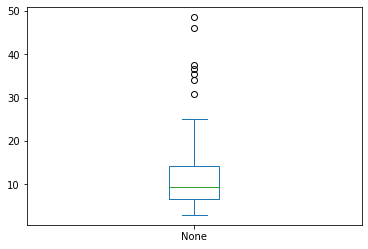

In [ ]:
distance = pd.Series(distance)
distance.plot(kind='box')

基本統計量算出

In [ ]:
tmp = distance.describe()
tmp

count    120.000000
mean      12.048917
std        8.607528
min        2.947477
25%        6.508124
50%        9.491413
75%       14.153812
max       48.556354
dtype: float64

四分位範囲を用いた外れ値の判定

In [ ]:
iqr = tmp['75%'] -tmp['25%']
jougen = 1.5 * (iqr) + tmp['75%']
kagen = tmp['25%'] - 1.5 * (iqr)
outliner = distance[(distance > jougen) | (distance < kagen)].index
print(outliner)

Int64Index([40, 43, 55, 88, 91, 94, 119], dtype='int64')


外れ値の削除

In [ ]:
test2 = test.drop(outliner,axis=0)
test2.head(30)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_1,Origin_2,Origin_3
0,14.0,8,351.0,153.000000,4129,13.0,72,1,0,0
1,25.0,4,140.0,75.000000,2542,17.0,74,1,0,0
2,13.0,8,302.0,140.000000,4294,16.0,72,1,0,0
3,21.0,4,120.0,87.000000,2979,19.5,72,0,1,0
4,18.0,6,232.0,100.000000,3288,15.5,71,1,0,0
5,35.0,4,72.0,69.000000,1613,18.0,71,0,0,1
6,34.1,4,86.0,65.000000,1975,15.2,79,0,0,1
7,20.0,4,140.0,90.000000,2408,19.5,72,1,0,0
8,15.0,8,400.0,150.000000,3761,9.5,70,1,0,0
9,23.5,6,173.0,110.000000,2725,12.6,81,1,0,0


テストデータの決定係数算出

①特徴量エンジニアリングの結果で評価

In [ ]:
col =  ['Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin_3']
x_test = test[col]
x_test['Weight2'] = test['Weight']**3
x_test['Displacement2'] = test['Displacement']**8
x_test['Horsepower2'] = test['Horsepower']**4
x_test['Model Year2'] = test['Model Year']**3
x_test['Acceleration2'] = test['Acceleration']**4
x_test['WD'] = test['Weight']*test['Displacement']
x_test['WH'] = test['Weight']*test['Horsepower']
x_test['WM'] = test['Weight']*test['Model Year']
x_test['DM'] = test['Displacement']*test['Model Year']
x_test['CA'] = test['Cylinders']*test['Acceleration']
y_test = test[['MPG']]
sc_model_x = StandardScaler()
sc_model_x.fit(x_test)
sc_x_test = sc_model_x.transform(x_test)
sc_model_y = StandardScaler()
sc_model_y.fit(y_test)
sc_y_test = sc_model_y.transform(y_test)
print('■テストデータの決定係数')
val1 = model.score(sc_x_test,sc_y_test)
print('　線形回帰　：',val1)
val2 = ridgemodel.score(sc_x_test,sc_y_test)
print('　リッジ回帰：',val2)
val3 = lassomodel.score(sc_x_test,sc_y_test)
print('　ラッソ回帰：',val3)
val4 = treemodel.score(sc_x_test,sc_y_test)
print('　回帰木　　：',val4)

■テストデータの決定係数
　線形回帰　： 0.8769001975640078
　リッジ回帰： 0.8690042097420344
　ラッソ回帰： 0.8226357956037667
　回帰木　　： 0.7703371128638585


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

②多項式特徴量と交互作用特徴量を一括生成したデータで評価

In [ ]:
col =  ['Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin_3']
x_test = test[col]
pf2 = PolynomialFeatures(degree=2,include_bias= False)
pf_x2 = pf2.fit_transform(x_test)
y_test = test[['MPG']]
psc_model_x = StandardScaler()
psc_model_x.fit(pf_x2)
psc_x_test = psc_model_x.transform(pf_x2)
psc_model_y = StandardScaler()
psc_model_y.fit(y_test)
psc_y_test = psc_model_y.transform(y_test)
print('■テストデータの決定係数')
val1 = model2.score(psc_x_test,psc_y_test)
print('　線形回帰　：',val1)
val2 = ridgemodel2.score(psc_x_test,psc_y_test)
print('　リッジ回帰：',val2)
val3 = lassomodel2.score(psc_x_test,psc_y_test)
print('　ラッソ回帰：',val3)
val4 = treemodel2.score(psc_x_test,psc_y_test)
print('　回帰木　　：',val4)

■テストデータの決定係数
　線形回帰　： 0.8521191528076278
　リッジ回帰： 0.8373769145294399
　ラッソ回帰： 0.8191850378911041
　回帰木　　： 0.8173167869998793


モデルの保存

In [ ]:
import pickle
with open('auto_mgp.pkl','wb') as f:
  pickle.dump(model,f)
with open('auto_mgp.pkl','wb') as f:
  pickle.dump(ridgemodel,f)
with open('auto_mgp.pkl','wb') as f:
  pickle.dump(lassomodel,f)
with open('auto_mgp.pkl','wb') as f:
  pickle.dump(treemodel,f)
with open('auto_mgp.pkl','wb') as f:
  pickle.dump(sc_model_x2,f)
with open('auto_mgp.pkl','wb') as f:
  pickle.dump(sc_model_y2,f)